In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
from GWForge.population.redshift import Redshift
import bilby
import numpy as np
import pylab as plt
import os
from glob import glob
import seaborn as sns
import pandas as pd
import dill
from tqdm import tqdm
from scipy.stats import ncx2
from pycbc.waveform import get_fd_waveform
import sys
sys.path.append('../../')
from utils import load_results_from_h5, save_results_to_h5, get_detected_SNRs

In [2]:
MDhigh_params = {'gamma':2.7, 'kappa':5.6, 'z_peak':2.53}
MDlow_params = {'gamma':2.7, 'kappa':5.6, 'z_peak':1.54}
MD_params = {'gamma':2.7, 'kappa':5.6, 'z_peak':1.9}

In [3]:
pop_num = 5

if pop_num == 4:
    pop_params = MDhigh_params
    MDmodel = 'MDhigh'
    z_str = f'z_{MDmodel}_zp_{pop_params["z_peak"]}'
elif pop_num == 5:
    pop_params = MDlow_params
    MDmodel = 'MDlow'
    z_str = f'z_{MDmodel}_zp_{pop_params["z_peak"]}'
else:
    pop_params = MD_params
    z_str = 'z_MD'

netw = 'LHI_Asharp'
#netw = 'CE4020ET123_CoBA10'

if 'Asharp' in netw:
    fref_str = '_fref_10'
elif 'CE4020ET123' in netw:
    if pop_num == 2:
        fref_str = ''
    else:
        fref_str = '_fref_5'
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
study_label = f'{netw}_SNR_{pop_num}_pop_PLP_spin_prec{fref_str}_{z_str}_zmax_10_lmrd_22_corrected_td'

In [4]:
#z_max = 6
z_max = 11
print(pop_params)
gwf_z = Redshift(redshift_model='MadauDickinson', 
                 local_merger_rate_density=22, 
                 maximum_redshift=z_max, 
                 gps_start_time=0, 
                 parameters=pop_params)
gwf_z_prob = gwf_z.coalescence_rate()

{'gamma': 2.7, 'kappa': 5.6, 'z_peak': 1.54}


Output()

In [5]:
#z_grid = np.arange(0, z_max, 0.001)
z_grid = np.arange(0, z_max, 0.001)
p_z = bilby.core.prior.Interped(z_grid, gwf_z_prob(z_grid))

## Check the probability function against input population

/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/input_population/BBH/5_pop_PLP_spin_prec_fref_10_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td.h5


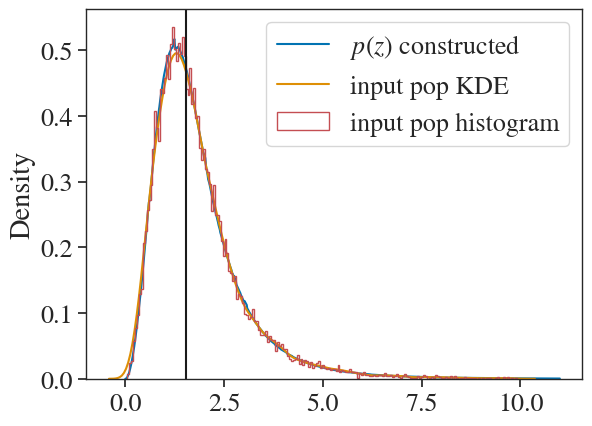

In [6]:
if pop_num == 2 and 'CE4020ET123' in netw:
    input_file = os.path.join(project_dir, 'input_population', 'BBH', 
                              '2_pop_PLP_spin_prec_z_MD_zmax_10_lmrd_22_365_days_corrected_td.h5')
else:
    input_file = glob(os.path.join(project_dir, 'input_population', 'BBH', f'{pop_num}_pop*{fref_str}*.h5'))[0]
print(input_file)
with h5py.File(input_file, 'r') as f:
#with h5py.File(glob(os.path.join(project_dir, 'input_population', 'BBH', '1_pop*.h5'))[0], 'r') as f:
    input_z = f['redshift'][:]
plt.plot(z_grid, p_z.probability_density(z_grid), label='$p(z)$ constructed')
sns.kdeplot(input_z, label='input pop KDE')
plt.hist(input_z, bins=200, histtype='step', density=True, label='input pop histogram', color='r');
plt.axvline(pop_params['z_peak'], c='k')
plt.legend()

## Load combined injection file

In [7]:
combined_inj_file = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 'combined_h5_files_select_params', 
                                 f'{study_label}_24M_points_XPHM_det_mf_from_gaussian.h5')
combined_inj_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/injections/combined_h5_files_select_params/LHI_Asharp_SNR_5_pop_PLP_spin_prec_fref_10_z_MDlow_zp_1.54_zmax_10_lmrd_22_corrected_td_24M_points_XPHM_det_mf_from_gaussian.h5'

In [8]:
injected_data = load_results_from_h5(combined_inj_file)
injected_data.keys()

dict_keys(['detected_mf_from_gaussian', 'total'])

In [9]:
injected_data['detected_mf_from_gaussian'] = pd.DataFrame(injected_data['detected_mf_from_gaussian'])

### Divide injections into mass bands

In [10]:
def slice_mtotal_pop(arr, mtotal_range):
    """
    Returns: A bool array corresponding to arr, depending on the range provided
    """
    if '<' in mtotal_range:
        max_boundary = float(mtotal_range.split('<')[-1])
        return(arr < max_boundary)
        
    elif '<=' in mtotal_range:
        max_boundary = float(mtotal_range.split('<=')[-1])
        return(arr <= max_boundary)
        
    elif '>' in mtotal_range:
        min_boundary = float(mtotal_range.split('>')[-1])
        return(arr > min_boundary)
        
    elif '>=' in mtotal_range:
        min_boundary = float(mtotal_range.split('>=')[-1])
        return(arr >= min_boundary)
        
    elif '-' in mtotal_range:
        min_boundary, max_boundary = map(float, mtotal_range.split('-'))
        return(np.all((arr >= min_boundary, arr <= max_boundary), axis=0))

In [11]:
injected_data['detected_mf_from_gaussian'].keys()

Index(['SNR_H1', 'SNR_I1', 'SNR_L1', 'SNR_mf_from_gaussian_network',
       'SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1',
       'SNR_mf_from_opt_network', 'SNR_network', 'distance', 'p_z', 'redshift',
       'srcmtotal'],
      dtype='object')

In [12]:
mass_ranges = ['<40', '40-80', '>80']
injected_data['mass_select'] = {}
print('Total detected events =', len(injected_data['detected_mf_from_gaussian']), f"({len(injected_data['detected_mf_from_gaussian'])*100/len(injected_data['total']['redshift']):.2f} %)")
for m_range in mass_ranges:
    print(m_range)
    injected_data['mass_select'][m_range] = {'detected_mf_from_gaussian': injected_data['detected_mf_from_gaussian'][slice_mtotal_pop(injected_data['detected_mf_from_gaussian']['srcmtotal'], m_range)].reset_index().rename(columns={'index':'old_index'})}
    injected_data['mass_select'][m_range]['total'] = pd.DataFrame(injected_data['total'])[slice_mtotal_pop(injected_data['total']['srcmtotal'], m_range)]
    print('Total =', len(injected_data['mass_select'][m_range]['total']), f"({len(injected_data['mass_select'][m_range]['total'])*100/len(injected_data['total']['srcmtotal']):.2f}%)")
    print('Detected =', len(injected_data['mass_select'][m_range]['detected_mf_from_gaussian']), f"({len(injected_data['mass_select'][m_range]['detected_mf_from_gaussian'])*100/len(injected_data['mass_select'][m_range]['total']):.2f}%)" '\n')

Total detected events = 3930838 (16.38 %)
<40
Total = 20436009 (85.15%)
Detected = 2139359 (10.47%)

40-80
Total = 3325563 (13.86%)
Detected = 1630275 (49.02%)

>80
Total = 238410 (0.99%)
Detected = 161204 (67.62%)



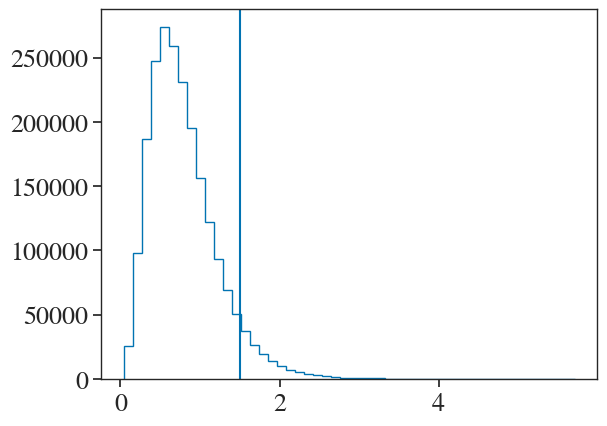

In [13]:
plt.hist(injected_data['mass_select']['<40']['detected_mf_from_gaussian']['redshift'], bins=50, histtype=u'step');
plt.axvline(1.5)
#plt.axvline(2)
#plt.axvline(1.2)

In [14]:
injected_data['mass_select']['<40']['detected_mf_from_gaussian']

,old_index,SNR_H1,SNR_I1,SNR_L1,SNR_mf_from_gaussian_network,SNR_mf_from_opt_H1,SNR_mf_from_opt_I1,SNR_mf_from_opt_L1,SNR_mf_from_opt_network,SNR_network,distance,p_z,redshift,srcmtotal
0,2,8.872421,8.795921,7.907635,13.622848,9.361132,9.495388,7.872004,15.484239,14.785763,5735.093409,0.419237,0.871664,16.050002
1,4,19.751867,14.189225,22.583639,34.568337,18.222563,15.553812,22.672444,32.985187,33.188720,3289.804370,0.235544,0.552455,37.237368
2,5,8.087840,12.187389,15.199971,20.722240,8.649482,11.167509,15.766410,21.168526,21.094661,4053.390797,0.299072,0.656397,19.683844
3,7,12.691616,0.772651,9.832714,14.605045,13.179907,1.562243,9.764627,16.477211,16.073468,6872.094044,0.471027,1.009578,25.203472
4,9,9.351107,14.888220,10.685002,19.402647,8.830331,15.510912,10.024081,20.470597,20.573564,6380.033543,0.451165,0.950510,22.793769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2139354,3930832,8.603072,8.060864,6.774679,13.966484,10.077767,8.433623,6.644875,14.725547,13.597303,4479.043705,0.334753,0.712445,21.346973
2139355,3930833,8.277684,4.411893,8.720043,13.261369,7.872421,4.533091,8.575852,12.492765,12.807186,4072.010237,0.300730,0.658875,38.092024
2139356,3930834,7.499587,8.699761,9.791121,15.939285,7.610826,8.030793,9.948630,14.879299,15.092902,6372.121306,0.450853,0.949553,18.054357
2139357,3930836,8.820465,9.644142,10.938191,16.758702,8.083334,9.556043,12.585099,17.749449,17.042714,11737.245128,0.467623,1.558496,31.893813


## Write to file

#### MF from gaussian SNR detected population

In [15]:
z_dict_write_mf_from_opt = {}
for m_range in mass_ranges:
    z_dict_write_mf_from_opt[m_range] = {'redshift':np.array(injected_data['mass_select'][m_range]['detected_mf_from_gaussian']['redshift']), 
                                         'prior':np.array(injected_data['mass_select'][m_range]['detected_mf_from_gaussian']['p_z']),
                                         'total_generated':len(injected_data['mass_select'][m_range]['total']['redshift'])}

In [16]:
z_dict_write_mf_from_opt

{'<40': {'redshift': array([0.87166371, 0.55245499, 0.65639725, ..., 0.9495533 , 1.5584957 ,
         0.29592415]),
  'prior': array([0.41923698, 0.23554356, 0.29907162, ..., 0.45085301, 0.46762345,
         0.08126441]),
  'total_generated': 20436009},
 '40-80': {'redshift': array([0.6022689 , 1.01842567, 2.77517804, ..., 0.8751939 , 1.30415276,
         0.41323649]),
  'prior': array([0.26908426, 0.47356625, 0.15304901, ..., 0.42096924, 0.50353164,
         0.14544581]),
  'total_generated': 3325563},
 '>80': {'redshift': array([1.55259071, 1.30579242, 1.91916097, ..., 1.80204906, 1.15107369,
         0.49073206]),
  'prior': array([0.46904464, 0.50361979, 0.36127168, ..., 0.39814038, 0.50050568,
         0.19633192]),
  'total_generated': 238410}}

In [17]:
def mass_range_names(range_name):
    return(range_name.replace('<', 'below_').replace('>', 'above_'))

In [18]:
for m_range in mass_ranges:
    num_points = z_dict_write_mf_from_opt[m_range]['total_generated']
    m_range_name = mass_range_names(m_range)
    write_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 'mass_bands', 'XPHM')
    os.makedirs(write_dir, exist_ok=True)
    with open(os.path.join(write_dir,
                           f'{study_label}_detected_injs_mf_from_gaussian_SNR_{num_points}_points_{m_range_name}.pkl'), 
              'wb') as f:
        dill.dump(z_dict_write_mf_from_opt[m_range], f)